In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
from comparers import ModelComparer
import matplotlib.pyplot as plt
from IPython.display import display
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate_counterfactual_fidelity, get_complexity
from surrogate_tree import train_surrogate_tree, tree_to_rules, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances, plot_tree_leafs_for_class,\
                 tree_to_constraint_matrix, constraint_matrix_to_rules, extract_rules, print_rules,\
                 evaluate, search_max_depth_parameter
from tasks.boston_housing import make_task3 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


# Explanations

In [3]:
mclass_diff = comparer.predict_mclass_diff(X)

In [4]:
ground_truth_per_class = {}
for label in comparer.difference_class_names:
    with open(f'ground_truth.{label}.pickle', 'rb') as f:
        ground_truth_per_class[label] = pickle.load(f)

In [5]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## Find Optimal Solution

In [6]:
%%time
metrics = search_max_depth_parameter(X, mclass_diff, feature_names, comparer.class_names, comparer.difference_classes, start=2, stop=20)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


CPU times: user 240 ms, sys: 7.63 ms, total: 248 ms
Wall time: 262 ms


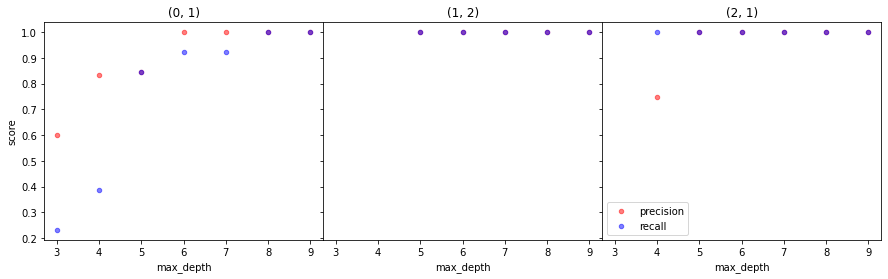

In [7]:
fig, axs = plt.subplots(ncols=3, sharex='all', sharey='all', figsize=(3*5, 4))
for label, ax in zip(np.unique(metrics['label']), axs):
    show_legend = ax == axs[-1]
    df = metrics.loc[metrics['label'] == label, :].reset_index()
    df.plot(kind='scatter', x='index', y='precision', label='precision', color='r', alpha=0.5, legend=show_legend, ax=ax)
    df.plot(kind='scatter', x='index', y='recall', label='recall', color='b', alpha=0.5, legend=show_legend, ax=ax)
    ax.set_xlabel('max_depth')
    ax.set_ylabel('score')
    ax.set_title(comparer.class_names[label])
    plt.subplots_adjust(wspace=.0, hspace=.0)
plt.savefig('boston-baseline-pr-curve.pdf')

In [8]:
df = metrics.copy()
df['label'] = comparer.class_names[metrics['label']]

- global explanation: setting 4
- local explanation: setting 8, which has equal precision and recall as setting 7, but fewer constraints

In [9]:
df[df['label'] == '(0, 1)']

,label,precision,recall,rules,constraints
3,"(0, 1)",0.600000,0.230769,1,3
4,"(0, 1)",0.833333,0.384615,2,7
5,"(0, 1)",0.846154,0.846154,4,16
6,"(0, 1)",1.000000,0.923077,5,22
7,"(0, 1)",1.000000,0.923077,5,20
8,"(0, 1)",1.000000,1.000000,6,29
9,"(0, 1)",1.000000,1.000000,6,28


- global/local explanation: setting 5

In [10]:
df[df['label'] == '(1, 2)']

,label,precision,recall,rules,constraints
5,"(1, 2)",1.0,1.0,1,4
6,"(1, 2)",1.0,1.0,1,4
7,"(1, 2)",1.0,1.0,1,4
8,"(1, 2)",1.0,1.0,1,4
9,"(1, 2)",1.0,1.0,1,4


- global/local explanation: setting 4

In [11]:
df[df['label'] == '(2, 1)']

,label,precision,recall,rules,constraints
4,"(2, 1)",0.75,1.0,2,7
5,"(2, 1)",1.00,1.0,2,8
6,"(2, 1)",1.00,1.0,2,9
7,"(2, 1)",1.00,1.0,2,9
8,"(2, 1)",1.00,1.0,2,9
9,"(2, 1)",1.00,1.0,2,8


## Tree with Depth 4

In [12]:
%%time
max_depth = 4
model = train_surrogate_tree(X, mclass_diff, max_depth=max_depth)
evaluate(model, X, mclass_diff, comparer.class_names);

CPU times: user 9.36 ms, sys: 1.88 ms, total: 11.2 ms
Wall time: 14.8 ms


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Precision,Recall,F1 Score,Support
"(0, 0)",0.925000,0.973684,0.948718,76
"(0, 1)",0.833333,0.384615,0.526316,13
"(1, 1)",0.904762,0.982759,0.942149,58
"(1, 2)",0.000000,0.000000,0.000000,1
"(2, 1)",0.750000,1.000000,0.857143,3
"(2, 2)",1.000000,0.978947,0.989362,95


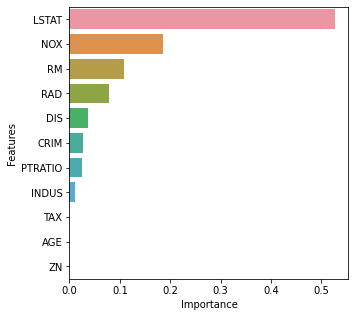

In [13]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

In [14]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)

In [15]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)

In [16]:
for label, rule, class_occurences_part in zip(labels, rules, class_occurences):
    if comparer.class_names[label] == '(0, 1)':
        print(f'\item ${rule}$ {class_occurences_part.astype(int).tolist()}')

\item $9.48 < \mathit{LSTAT} \leq 12.61 \land \mathit{NOX} > 0.59 \land \mathit{INDUS} > 18.84$ [0, 3, 0, 0, 0, 0]
\item $\mathit{LSTAT} > 17.52 \land \mathit{NOX} \leq 0.59 \land \mathit{PTRATIO} > 20.60$ [1, 2, 0, 0, 0, 0]


In [17]:
for label, rule, class_occurences_part in zip(labels, rules, class_occurences):
    if comparer.class_names[label] == '(2, 1)':
        print(f'\item ${rule}$ {class_occurences_part.astype(int).tolist()}')

\item $\mathit{LSTAT} \leq 9.48 \land \mathit{RM} \leq 6.62 \land \mathit{RAD} > 6.00 \land \mathit{DIS} > 1.48$ [0, 0, 0, 0, 2, 1]
\item $\mathit{LSTAT} \leq 9.48 \land \mathit{RM} > 6.62 \land \mathit{CRIM} > 0 \land \mathit{PTRATIO} > 20.60$ [0, 0, 0, 0, 1, 0]


### Evaluation

#### Global Fidelity

In [18]:
scores = evaluate(model, X, mclass_diff, comparer.class_names)
global_fidelities[max_depth] = scores
scores

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,Precision,Recall,F1 Score,Support
"(0, 0)",0.925000,0.973684,0.948718,76
"(0, 1)",0.833333,0.384615,0.526316,13
"(1, 1)",0.904762,0.982759,0.942149,58
"(1, 2)",0.000000,0.000000,0.000000,1
"(2, 1)",0.750000,1.000000,0.857143,3
"(2, 2)",1.000000,0.978947,0.989362,95


#### Counterfactual Fidelity Error

##### (0, 1)

In [19]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [20]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule_focus,
                                                      constraints_focus)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [21]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,NaN,1.000000,NaN
ZN,NaN,1.000000,NaN
INDUS,4.985777,0.500000,0.0
NOX,NaN,NaN,1.0
RM,NaN,1.000000,NaN
AGE,NaN,1.000000,NaN
DIS,NaN,1.000000,NaN
RAD,NaN,1.000000,NaN
TAX,NaN,1.000000,NaN
PTRATIO,0.374834,0.666667,0.0


##### (2, 1)

In [22]:
focus_class_idx, focus_class = comparer.check_class('(2, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [23]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule_focus,
                                                      constraints_focus)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [24]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,NaN,1.0,1.0
ZN,NaN,1.0,NaN
INDUS,NaN,1.0,NaN
NOX,NaN,NaN,NaN
RM,1.361463,0.4,0.0
AGE,NaN,1.0,NaN
DIS,1.137869,0.8,0.5
RAD,11.720004,0.5,0.0
TAX,NaN,1.0,NaN
PTRATIO,NaN,1.0,1.0


#### Complexity

##### (0, 1)

In [25]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [26]:
res = get_complexity(constraints_focus)
complexities[(max_depth, focus_class)] = res
res

Rules          2
Constraints    7
dtype: int64

##### (2, 1)

In [27]:
focus_class_idx, focus_class = comparer.check_class('(2, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [28]:
res = get_complexity(constraints_focus)
complexities[(max_depth, focus_class)] = res
res

Rules          2
Constraints    8
dtype: int64

## Tree with Depth 5

In [57]:
%%time
max_depth = 5
model = train_surrogate_tree(X, mclass_diff, max_depth=max_depth)
evaluate(model, X, mclass_diff, comparer.class_names);

CPU times: user 6.78 ms, sys: 2.29 ms, total: 9.06 ms
Wall time: 7.45 ms


,Precision,Recall,F1 Score,Support
"(0, 0)",0.986842,0.986842,0.986842,76
"(0, 1)",0.846154,0.846154,0.846154,13
"(1, 1)",0.965517,0.965517,0.965517,58
"(1, 2)",1.000000,1.000000,1.000000,1
"(2, 1)",1.000000,1.000000,1.000000,3
"(2, 2)",1.000000,1.000000,1.000000,95


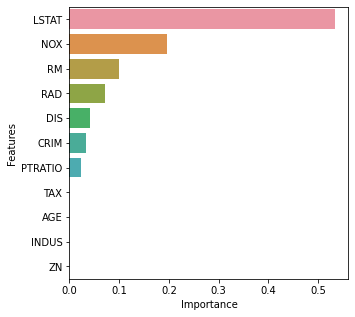

In [58]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

In [59]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)

In [60]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)

In [61]:
for label, rule, class_occurences_part in zip(labels, rules, class_occurences):
    if comparer.class_names[label] == '(1, 2)':
        print(f'\item ${rule}$ {class_occurences_part.astype(int).tolist()}')

\item $\mathit{LSTAT} \leq 6.26 \land \mathit{RM} \leq 6.62 \land \mathit{RAD} \leq 6.00 \land \mathit{DIS} \leq 7.10$ [0, 0, 0, 1, 0, 0]


### Evaluation

#### Global Fidelity

In [35]:
scores = evaluate(model, X, mclass_diff, comparer.class_names)
global_fidelities[max_depth] = scores
scores

,Precision,Recall,F1 Score,Support
"(0, 0)",0.986842,0.986842,0.986842,76
"(0, 1)",0.846154,0.846154,0.846154,13
"(1, 1)",0.965517,0.965517,0.965517,58
"(1, 2)",1.000000,1.000000,1.000000,1
"(2, 1)",1.000000,1.000000,1.000000,3
"(2, 2)",1.000000,1.000000,1.000000,95


#### Counterfactual Fidelity Error

##### (1, 2)

In [36]:
focus_class_idx, focus_class = comparer.check_class('(1, 2)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [37]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule_focus,
                                                      constraints_focus)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [38]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,NaN,1.0,NaN
ZN,NaN,1.0,NaN
INDUS,NaN,1.0,NaN
NOX,NaN,NaN,NaN
RM,1.120368,0.5,0.0
AGE,NaN,1.0,NaN
DIS,NaN,1.0,NaN
RAD,4.754540,0.0,0.0
TAX,NaN,NaN,NaN
PTRATIO,NaN,1.0,NaN


#### Complexity

##### (1, 2)

In [39]:
focus_class_idx, focus_class = comparer.check_class('(1, 2)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [40]:
res = get_complexity(constraints_focus)
complexities[(max_depth, focus_class)] = res
res

Rules          1
Constraints    4
dtype: int64

## Tree with Depth 8

In [62]:
%%time
max_depth = 8
model = train_surrogate_tree(X, mclass_diff, max_depth=max_depth)
evaluate(model, X, mclass_diff, comparer.class_names);

CPU times: user 8.33 ms, sys: 15.1 ms, total: 23.5 ms
Wall time: 25.8 ms


,Precision,Recall,F1 Score,Support
"(0, 0)",1.0,1.0,1.0,76
"(0, 1)",1.0,1.0,1.0,13
"(1, 1)",1.0,1.0,1.0,58
"(1, 2)",1.0,1.0,1.0,1
"(2, 1)",1.0,1.0,1.0,3
"(2, 2)",1.0,1.0,1.0,95


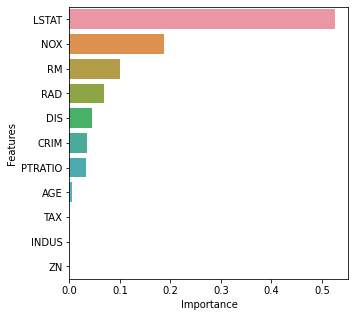

In [63]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

In [64]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)

In [65]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)

In [66]:
for label, rule, class_occurences_part in zip(labels, rules, class_occurences):
    if comparer.class_names[label] == '(0, 1)':
        print(f'\item ${rule}$ {class_occurences_part.astype(int).tolist()}')

\item $16.29 < \mathit{LSTAT} \leq 17.72 \land \mathit{NOX} > 0.59 \land \mathit{CRIM} \leq 1$ [0, 4, 0, 0, 0, 0]
\item $9.48 < \mathit{LSTAT} \leq 12.61 \land 0.59 < \mathit{NOX} \leq 0.62$ [0, 3, 0, 0, 0, 0]
\item $\mathit{LSTAT} > 17.52 \land \mathit{NOX} \leq 0.59 \land \mathit{DIS} > 3.79 \land \mathit{PTRATIO} > 20.60$ [0, 2, 0, 0, 0, 0]
\item $16.72 < \mathit{LSTAT} \leq 17.52 \land \mathit{NOX} \leq 0.59 \land 2.27 < \mathit{DIS} \leq 5.52$ [0, 2, 0, 0, 0, 0]
\item $12.61 < \mathit{LSTAT} \leq 14.31 \land \mathit{NOX} > 0.59 \land \mathit{DIS} > 2.12 \land \mathit{CRIM} > 1$ [0, 1, 0, 0, 0, 0]
\item $9.48 < \mathit{LSTAT} \leq 16.72 \land 0.49 < \mathit{NOX} \leq 0.59 \land \mathit{DIS} > 2.27 \land \mathit{PTRATIO} \leq 16.50 \land \mathit{AGE} > 0$ [0, 1, 0, 0, 0, 0]


### Evaluation

#### Global Fidelity

In [45]:
scores = evaluate(model, X, mclass_diff, comparer.class_names)
global_fidelities[max_depth] = scores
scores

,Precision,Recall,F1 Score,Support
"(0, 0)",1.0,1.0,1.0,76
"(0, 1)",1.0,1.0,1.0,13
"(1, 1)",1.0,1.0,1.0,58
"(1, 2)",1.0,1.0,1.0,1
"(2, 1)",1.0,1.0,1.0,3
"(2, 2)",1.0,1.0,1.0,95


#### Counterfactual Fidelity Error

##### (0, 1)

In [46]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [47]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule_focus,
                                                      constraints_focus)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [48]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
CRIM,0.794867,0.631579,0.0
ZN,6.250000,0.846154,0.0
INDUS,NaN,1.000000,NaN
NOX,NaN,NaN,1.0
RM,NaN,1.000000,1.0
AGE,NaN,1.000000,NaN
DIS,NaN,1.000000,1.0
RAD,NaN,1.000000,NaN
TAX,20.500000,0.956522,0.0
PTRATIO,0.432782,0.833333,0.0


#### Complexity

##### (0, 1)

In [49]:
focus_class_idx, focus_class = comparer.check_class('(0, 1)')
ground_truth_instance_indices, ground_truth = ground_truth_per_class[focus_class]
constraints_focus, rules_focus, class_occurences_focus, instance_indices_per_rule_focus =\
    zip(*[(constraint, rule, class_occurences, instance_indices)
     for constraint, rule, class_occurences, label, instance_indices
     in zip(constraints, rules, class_occurences, labels, instance_indices_per_rule)
     if label == focus_class_idx])

In [50]:
res = get_complexity(constraints_focus)
complexities[(max_depth, focus_class)] = res
res

Rules           6
Constraints    28
dtype: int64

# Summary

In [51]:
def map_index(index):
    class_, depth = index[0], index[1]
    if class_ == '(0, 1)' and depth == 4:
        level = 'global'
    elif class_ == '(0, 1)' and depth == 8:
        level = 'local'
    elif class_ == '(1, 2)' and depth == 5:
        level = 'global'
    elif class_ == '(2, 1)' and depth == 4:
        level = 'global'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [52]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('depth', 'class'))
global_fidelity = global_fidelity[np.in1d(global_fidelity.index.get_level_values('class'), comparer.difference_class_names)]
global_fidelity = global_fidelity.reorder_levels(['class', 'depth']).sort_index()
global_fidelity

Precision    Recall  F1 Score  Support
class  depth                                        
(0, 1) 4       0.833333  0.384615  0.526316       13
       5       0.846154  0.846154  0.846154       13
       8       1.000000  1.000000  1.000000       13
(1, 2) 4       0.000000  0.000000  0.000000        1
       5       1.000000  1.000000  1.000000        1
       8       1.000000  1.000000  1.000000        1
(2, 1) 4       0.750000  1.000000  0.857143        3
       5       1.000000  1.000000  1.000000        3
       8       1.000000  1.000000  1.000000        3

## Local Fidelity

In [53]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('depth', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'depth', 'feature']).sort_index()
local_fidelity

RMSE       BMR  BAR
class  depth feature                          
(0, 1) 4     AGE            NaN  1.000000  NaN
             CRIM           NaN  1.000000  NaN
             DIS            NaN  1.000000  NaN
             INDUS     4.985777  0.500000  0.0
             LSTAT     0.776577  0.200000  0.0
             NOX            NaN       NaN  1.0
             PTRATIO   0.374834  0.666667  0.0
             RAD            NaN  1.000000  NaN
             RM             NaN  1.000000  NaN
             TAX            NaN  1.000000  NaN
             ZN             NaN  1.000000  NaN
       8     AGE            NaN  1.000000  NaN
             CRIM      0.794867  0.631579  0.0
             DIS            NaN  1.000000  1.0
             INDUS          NaN  1.000000  NaN
             LSTAT     1.573000  0.076923  0.0
             NOX            NaN       NaN  1.0
             PTRATIO   0.432782  0.833333  0.0
             RAD            NaN  1.000000  NaN
             RM             NaN  1.000000  1.0
             TAX      20.500000  0.956522  0.0
             ZN        6.250000  0.846154  0.0
(1, 2) 5     AGE            NaN  1.000000  NaN
             CRIM           NaN  1.000000  NaN
             DIS            NaN  1.000000  NaN
             INDUS          NaN  1.000000  NaN
             LSTAT     0.015000  0.500000  0.0
             NOX            NaN       NaN  NaN
             PTRATIO        NaN  1.000000  NaN
             RAD       4.754540  0.000000  0.0
             RM        1.120368  0.500000  0.0
             TAX            NaN       NaN  NaN
             ZN             NaN  1.000000  NaN
(2, 1) 4     AGE            NaN  1.000000  NaN
             CRIM           NaN  1.000000  1.0
             DIS       1.137869  0.800000  0.5
             INDUS          NaN  1.000000  NaN
             LSTAT     1.746977  0.500000  0.0
             NOX            NaN       NaN  NaN
             PTRATIO        NaN  1.000000  1.0
             RAD      11.720004  0.500000  0.0
             RM        1.361463  0.400000  0.0
             TAX            NaN  1.000000  NaN
             ZN             NaN  1.000000  NaN

## Complexity

In [54]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('depth', 'class')).T
complexity = complexity.reorder_levels(['class', 'depth']).sort_index()
complexity

Rules  Constraints
class  depth                    
(0, 1) 4          2            7
       8          6           28
(1, 2) 5          1            4
(2, 1) 4          2            8

## Generation Time

<1s

In [55]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('depth').notnull()]
global_fidelity.index.rename(['class', 'level'], inplace=True)

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('depth').notnull()]
local_fidelity.index.rename(['class', 'level', 'feature'], inplace=True)

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('depth').notnull()]
complexity.index.rename(['class', 'level'], inplace=True)

with open('results.baseline.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)